# Goal of the notebook:

To apply Annealed Langevin Posterior Sampling algorithm using energy model for inpainting inverse problem 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from dataclasses import dataclass


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import dnnlib
from training.dataset import ImageFolderDataset
from operators import *
from utils import Denoiser,giveScore
from utils import ALPS

# Load data and networks

In [2]:
import pickle
network_pkl = './models/edm_diffusion/face_dataset/edm-ffhq-64x64-uncond-ve.pkl'
with dnnlib.util.open_url(network_pkl) as f:
    net0 = pickle.load(f)['ema'].to(device)
net = Denoiser(net0).to(device)        
net_path ="./models/score_distillation/face_dataset/best_model_epoch_36.pth"
state_dict = torch.load(net_path, map_location=device)
net.load_state_dict(state_dict)
s=net.eval()

# Dataset

In [3]:
dataset = ImageFolderDataset('./datasets/ffhq-64x64.zip', resolution=64,xflip=False)

(xorig, _) = dataset[4]
xorig = torch.tensor(xorig).to(device) / 127.5 - 1

xorig = torch.unsqueeze(xorig,0)


def to_img(img):
    img = img.detach().cpu().clamp(-1,1)
    img = (img + 1) / 2.0
    return img.permute(0,2,3,1).squeeze(0).numpy()

# Inpainting with box

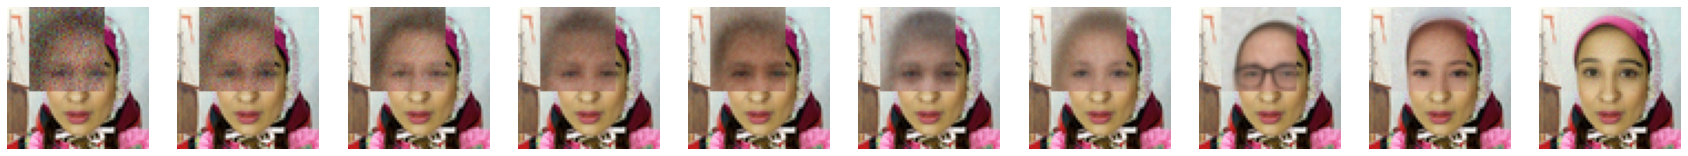

In [4]:
mask_gen = mask_generator(mask_type="box" ,mask_len_range=[30,40], mask_prob_range=[0.8,0.8],image_size=64,margin=(0, 0))  
mask = mask_gen(xorig)
eta = 0.01
A = Inpainting(mask,eta=eta).to(device)
y = A.forward(xorig)
y = y+eta*torch.randn_like(y)

# ALPS Reconstruction

@dataclass
class Options:
    num_steps: int = 50
    sigma_max: float = 100
    sigma_min: float = 0.1
    rho: float = 5
    K: int = 5
opts = Options()

x_final,xarray = ALPS(A, net, y, opts, isALPS=True,  storeIntermediate=True)

if(xarray.shape[0]>10):
    step = xarray.shape[0]//10
    xarray = xarray[::step]
fig, ax = plt.subplots(1,xarray.shape[0], figsize=(xarray.shape[0]*3,3))    
for i in range(xarray.shape[0]):
    ax[i].imshow(to_img(xarray[i:i+1])); ax[i].axis('off')

